1. ADF :  -3.157670556332803
2. P-Value :  0.022569380626571618
3. Num Of Lags :  23
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1802
5. Critical Values :
	 1% :  -3.4339840952648695
	 5% :  -2.8631452508003057
	 10% :  -2.567624583142913
Series is Stationary
CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 5.72 µs
avg_smape_hw Holt Winters :  19.096666666666664
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs

*****Running for store - 1**********
Initial log joint probability = -20.2583
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3164.52   0.000842344       87.9429      0.4011           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       3164.69   0.000437827       206.008   5.092e-06       0.001      212  LS failed, Hessian reset 
     182       3165.02   1.35065e-08       78.3269     0.06997    

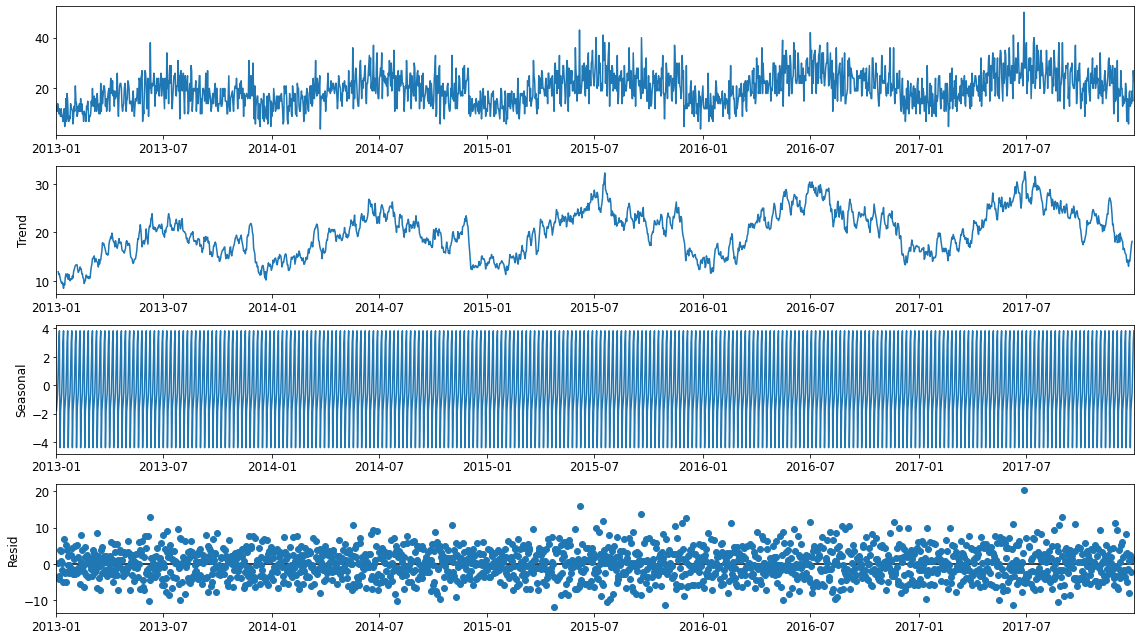

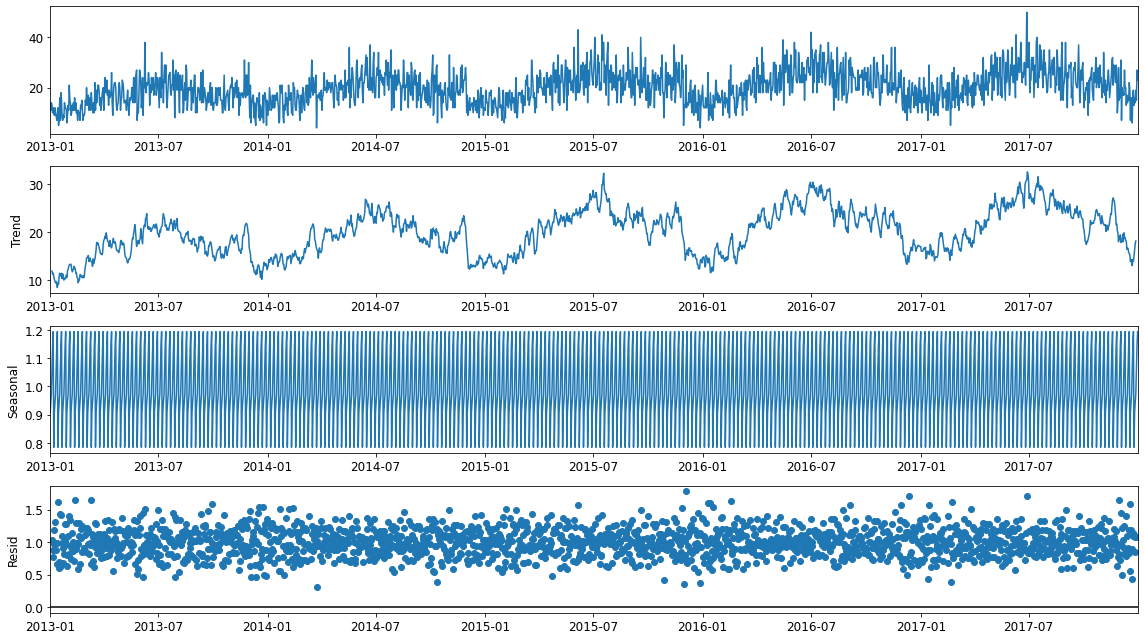

In [6]:
# Importing Libraries

import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (16,9)
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['axes.labelsize'] = 12

import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from datetime import timedelta, date, datetime

from statsmodels.tsa.holtwinters import ExponentialSmoothing
#import statsmodels.api as sm

from pandas import to_datetime

import plotly
import fbprophet
from fbprophet import Prophet
# print version number
#print('Prophet %s' % fbprophet.__version__)


# Reading the data

data_path = os.path.join(os.getcwd(), "Data/")

df = pd.read_csv(data_path +'train.csv', parse_dates=['date'])

df['store'] = df['store'].astype('category')
df['item'] = df['item'].astype('category')
df['sales'] = df['sales'].astype('int32')

############  EDA  #############

df.head()

df.tail()

# 10 stores * 50 items = 500 models in the loop
# Finding the seasonality & trend for the individual store-item combination

df_1 = df[(df['store'] == 1) & (df['item'] == 1)]
data = df_1.drop(columns=['store', 'item'], axis = 1)
data = data.groupby(['date']).agg({'sales' : 'sum'})

#decompose_data = seasonal_decompose(data, model="additive", freq=365)
decompose_data = seasonal_decompose(data, model="additive")
decompose_data.plot();

#decompose_data = seasonal_decompose(data, model="mul", freq=365)
decompose_data = seasonal_decompose(data, model="mul")
decompose_data.plot();

dftest = adfuller(data.sales, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

if dftest[1] > 0.05 :
    print('Series is not Stationary')
else:
    print('Series is Stationary')


################# Modelling ################
    
# Defining the error metric

def SMAPE (forecast, actual):
    """Returns the Symmetric Mean Absolute Percentage Error between two Series"""
    masked_arr = ~((forecast==0)&(actual==0))
    diff = abs(forecast[masked_arr] - actual[masked_arr])
    avg = (abs(forecast[masked_arr]) + abs(actual[masked_arr]))/2
    
    #print('SMAPE Error Score: ' + str(round(sum(diff/avg)/len(forecast) * 100, 2)) + ' %')
    
    smape_score = (round(sum(diff/avg)/len(forecast) * 100, 2))
    
    return smape_score

# Subset the entire dataset based on each store-item combination

def item_df_subset(df_1, item):
    df_2 = df_1[df_1['item'] == item]
    data = df_2.drop(columns=['store', 'item'], axis = 1)
    #data = data.groupby(['date']).agg({'sales' : 'sum'})
    train_len = int(0.9*len(data))

    train_data = data[:train_len] 
    test_data = data[train_len:]
    
    return train_data, test_data

# Holt - Winters Smoothing Model

def define_hw_model(train_data, test_data, store, item):
    
    train_data = train_data.groupby(['date']).agg({'sales' : 'sum'})
    test_data = test_data.groupby(['date']).agg({'sales' : 'sum'})
    
    hw_model = ExponentialSmoothing(train_data['sales'],trend='add',seasonal='add',seasonal_periods=365).fit()
    test_predictions = hw_model.forecast(len(test_data)).rename('HW Test Forecast')

    forecast_predictions = hw_model.forecast(steps=90)

    start_date = datetime.strptime('2018-01-01', "%Y-%m-%d")
    end_date = datetime.strptime('2018-04-01', "%Y-%m-%d")

    dates_list = pd.Series(pd.date_range(start_date,end_date-timedelta(days=1),freq='d'))
    forecast_dates = pd.DataFrame(data = dates_list, columns=['Date'])

    forecast_sales = pd.DataFrame(data = forecast_predictions, columns=['sales']).reset_index()

    smape_in_loop = pd.Series(SMAPE(test_predictions, test_data['sales']))
    
    #smape_in_loop = pd.Series(calculate_smape)
    
    #smape_item_list.append(smape_in_loop)

    forecast_sales['store'] = store

    #print('forecast_sales head\n', forecast_sales.head())

    forecast_sales['item'] = item

    forecast_df = pd.concat([forecast_dates, forecast_sales], axis = 1)

    forecast_df.drop('index', axis =1, inplace=True)
    
    forecast_df['sales'] = forecast_df['sales'].astype('int')
    
    return forecast_df, smape_in_loop


# Running for all the stores and items
store_list = df.store.unique()
item_list = df.item.unique()

#### Running for 3 stores and 4 items
#store_list = [1, 2, 3]
#item_list = [1, 2, 3, 4]

## Holt Winters Model

def run_hw_model(df, store_list, item_list):
    
    store_forecast_list = []
    smape_store_list = []

    for store in store_list:

        df_1 = df[df['store'] == store]

        #print('store : ', store)

        item_forecast_list = []
        smape_item_list = []

        for item in item_list:

            train_data, test_data = item_df_subset(df_1, item)

            forecast_df, smape_in_loop = define_hw_model(train_data, test_data, store, item)
            
            item_forecast_list.append(forecast_df)
            smape_item_list.append(smape_in_loop)

        item_forecast_df = pd.concat(item_forecast_list)

        store_forecast_list.append(item_forecast_df)

        item_concat_smape = pd.concat(smape_item_list) 
        smape_store_list.append(item_concat_smape)

    store_item_forecast_df = pd.concat(store_forecast_list)
    
    store_concat_smape = pd.concat(smape_store_list)
    avg_smape_hw = np.mean(store_concat_smape)

    return store_item_forecast_df, avg_smape_hw

%time
store_item_forecast_df, avg_smape_hw = run_hw_model(df, store_list, item_list)

store_item_forecast_df.tail()

store_item_forecast_df.shape

print('avg_smape_hw Holt Winters : ', avg_smape_hw)

#len(store_concat_smape)


## Prophet Model


def define_prophet_model(df_train, df_test, store, item):

    df_train.rename(columns={'date' : 'ds', 'sales' : 'y'}, inplace = True)
    df_train = df_train.reset_index(drop=True)

    df_test.rename(columns={'date' : 'ds', 'sales' : 'y'}, inplace = True)
    df_test = df_test.reset_index(drop=True)

    model = Prophet(daily_seasonality=True, interval_width=0.95);
    model = model.fit(df_train);

    future = pd.DataFrame(df_test['ds'])
    future.columns = ['ds']
    future['ds'] = to_datetime(future['ds'])

    test_predictions = model.predict(future);

    smape_in_loop = pd.Series(SMAPE((test_predictions['yhat']), (df_test['y'])))
    
    #item_smape_series = pd.Series(smape_item_list)

    start_date = datetime.strptime('2018-01-01', "%Y-%m-%d")
    end_date = datetime.strptime('2018-04-01', "%Y-%m-%d")
    dates_list = pd.Series(pd.date_range(start_date,end_date-timedelta(days=1),freq='d'))
    forecast_dates = pd.DataFrame(data = dates_list, columns=['ds'])

    forecast_3months = model.predict(forecast_dates)
    forecast_3months['yhat'] = (forecast_3months['yhat'].astype('int'))

    forecast_sales = forecast_3months[['ds', 'yhat']]
    forecast_sales.rename(columns = {'ds':'Date', 'yhat':'sales'}, inplace = True)
    forecast_sales['store'] = store
    forecast_sales['item'] = item

    return forecast_sales, smape_in_loop


#train_data.head()


def run_prophet_model(df, store_list, item_list):

    store_forecast_list = []
    smape_store_list = []

    for store in store_list:

        df_1 = df[df['store'] == store]
        #print('df_1 subset')
        print('\n*****Running for store - %d**********'% store)

        item_forecast_list = []
        smape_item_list = []

        for item in item_list:

            df_train, df_test = item_df_subset(df_1, item)

            forecast_sales, smape_in_loop = define_prophet_model(df_train, df_test, store, item)

            item_forecast_list.append(forecast_sales)
            smape_item_list.append(smape_in_loop)
            

        print('len of smape_item_list', len(smape_item_list))
        item_forecast_df = (pd.concat(item_forecast_list))
        store_forecast_list.append(item_forecast_df)
        
        item_concat_smape = pd.concat(smape_item_list) 
        smape_store_list.append(item_concat_smape)
        
        
    store_item_forecast_df = pd.concat(store_forecast_list)
    print('len of smape_store_list', len(smape_store_list))
    #print(smape_store_list)
    store_concat_smape = pd.concat(smape_store_list)

    print('\n********Done*********\n')
    
    avg_smape_prophet = np.mean(store_concat_smape)

    return store_item_forecast_df, avg_smape_prophet

%time
store_item_forecast_prophet, avg_smape_prophet = run_prophet_model(df, store_list, item_list)

#store_concat_smape

print('avg_smape Prophet : ', avg_smape_prophet)


In [7]:
avg_smape_prophet

13.765